In [1]:
!pip install idx2numpy

In [21]:
import keras
from keras.models import Sequential
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Flatten, Dense, Lambda, Input
from keras import layers , activations , models , preprocessing , utils
from keras import backend as K
from sklearn.model_selection import train_test_split
import tensorflow as tf 
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
import sklearn.cluster as cluster
import sklearn.metrics as metrics
import gzip
import numpy as np
import matplotlib.pyplot as plt
import idx2numpy
from sklearn.metrics.cluster import fowlkes_mallows_score
from sklearn.metrics.cluster import adjusted_mutual_info_score
from sklearn.metrics.cluster import rand_score
from sklearn.metrics.cluster import adjusted_rand_score
import random

random.seed(10)

(28, 28)

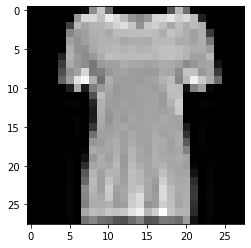

In [3]:
imagefile = gzip.open('train-images-idx3-ubyte.gz','r')
imagearray = idx2numpy.convert_from_file(imagefile)

#Vẽ thử một tấm ảnh xám thứ 10
plt.imshow(imagearray[10], cmap='gray')
imagearray[10].shape

In [4]:
#Đọc ảnh
imagefile = gzip.open('train-images-idx3-ubyte.gz','r')
imagearray = idx2numpy.convert_from_file(imagefile)

#Tiền xử lí ảnh bằng cách chuẩn hóa ảnh về miền giá trị 0-1
imagearray = imagearray.astype('float32') / 255

#Đọc nhãn của ảnh
labelfile = gzip.open('train-labels-idx1-ubyte.gz','r')
imagelabel = idx2numpy.convert_from_file(labelfile)

#Chia tập train và test theo tỉ lệ 80%-20%
X_train, X_test, y_train, y_test = train_test_split(imagearray, imagelabel, test_size=0.2, stratify=imagelabel, random_state=123)
X_train_reshape = np.asarray(X_train).astype('float32').reshape((X_train.shape[0], X_train.shape[1], X_train.shape[2], 1))

In [5]:
#Hàm sampling để tạo ra 
def sampling(mu_log_variance):
  mu, log_variance = mu_log_variance
  epsilon = keras.backend.random_normal(shape=keras.backend.shape(mu), mean=0.0, stddev=1.0)
  random_sample = mu + keras.backend.exp(log_variance/2) * epsilon
  return random_sample

In [6]:
#Hàm mất mát
def loss_func(encoder_mu, encoder_log_variance):
  def vae_reconstruction_loss(y_true, y_predict):
      reconstruction_loss_factor = 1000
      reconstruction_loss = keras.backend.mean(keras.backend.square(y_true-y_predict), axis=[1, 2, 3])
      return reconstruction_loss_factor * reconstruction_loss

  def vae_kl_loss(encoder_mu, encoder_log_variance):
      kl_loss = -0.5 * keras.backend.sum(1.0 + encoder_log_variance - keras.backend.square(encoder_mu) - keras.backend.exp(encoder_log_variance), axis=1)
      return kl_loss

  def vae_kl_loss_metric(y_true, y_predict):
      kl_loss = -0.5 * keras.backend.sum(1.0 + encoder_log_variance - keras.backend.square(encoder_mu) - keras.backend.exp(encoder_log_variance), axis=1)
      return kl_loss

  def vae_loss(y_true, y_predict):
      reconstruction_loss = vae_reconstruction_loss(y_true, y_predict)
      kl_loss = vae_kl_loss(y_true, y_predict)

      loss = reconstruction_loss + kl_loss
      return loss

  return vae_loss

In [7]:
#Tạo mô hình encoder

# Lớp input của encoder
encoder_input = keras.Input(shape=(28, 28, 1), name='encoder_input')

#Lớp convolutional thứ 1
encoder_convolutional_layer_1 = layers.Conv2D(filters=1, kernel_size=(3, 3), activation='relu', name='encoder_convolutional_layer_1')(encoder_input)
encoder_normalization_layer_1 = layers.BatchNormalization(name="encoder_normalization_layer_1")(encoder_convolutional_layer_1)

#Lớp convolutional thứ 2
encoder_convolutional_layer_2 = layers.Conv2D(filters=32, kernel_size=(3, 3), activation='relu', name='encoder_convolutional_layer_2')(encoder_normalization_layer_1)
encoder_normalization_layer_2 = layers.BatchNormalization(name="encoder_normalization_layer_2")(encoder_convolutional_layer_2)

#Lớp convolutional thứ 3
encoder_convolutional_layer_3 = layers.Conv2D(filters=64, kernel_size=(3, 3), activation='relu', name='encoder_convolutional_layer_3')(encoder_normalization_layer_2)
encoder_normalization_layer_3 = layers.BatchNormalization(name="encoder_normalization_layer_3")(encoder_convolutional_layer_3)

#Lớp convolutional thứ 4
encoder_convolutional_layer_4 = layers.Conv2D(filters=64, kernel_size=(3, 3), activation='relu', name='encoder_convolutional_layer_4')(encoder_normalization_layer_3)
encoder_normalization_layer_4 = layers.BatchNormalization(name="encoder_normalization_layer_4")(encoder_convolutional_layer_4)

#Lớp convolutional thứ 5
encoder_convolutional_layer_5 = layers.Conv2D(filters=64, kernel_size=(3, 3), activation='relu', name='encoder_convolutional_layer_5')(encoder_normalization_layer_4)
encoder_normalization_layer_5 = layers.BatchNormalization(name="encoder_normalization_layer_5")(encoder_convolutional_layer_5)

#Lớp làm phẳng
encoder_flatten = layers.Flatten()(encoder_normalization_layer_5)

#Tham số điều chỉnh số node ở latent space
latent_space_dim = 2

#Tạo ra vector mu
encoder_mu = keras.layers.Dense(units=latent_space_dim, name="encoder_mu")(encoder_flatten)
encoder_log_variance = keras.layers.Dense(units=latent_space_dim, name="encoder_log_variance")(encoder_flatten)

encoder_output = layers.Lambda(sampling)([encoder_mu, encoder_log_variance])

encoder_model = models.Model(encoder_input, encoder_output, name="encoder_model")
encoder_model.summary()

Model: "encoder_model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 encoder_input (InputLayer)     [(None, 28, 28, 1)]  0           []                               
                                                                                                  
 encoder_convolutional_layer_1   (None, 26, 26, 1)   10          ['encoder_input[0][0]']          
 (Conv2D)                                                                                         
                                                                                                  
 encoder_normalization_layer_1   (None, 26, 26, 1)   4           ['encoder_convolutional_layer_1[0
 (BatchNormalization)                                            ][0]']                           
                                                                                      

In [8]:
#Tạo mô hình decoder

decoder_input = keras.layers.Input(shape=(latent_space_dim))

decoder_dense_layer_1 = keras.layers.Dense(units=7 * 7 * 64, name="decoder_dense_layer_1")(decoder_input)

decoder_reshape = keras.layers.Reshape(target_shape=(7, 7, 64))(decoder_dense_layer_1)

decoder_convolutional_tranpose_layer_1 = keras.layers.Conv2DTranspose(filters=64, kernel_size=(3, 3), padding='same', strides=1, activation='relu', name="decoder_convolutional_tranpose_layer_1")(decoder_reshape)
decoder_normalization_layer_1 = layers.BatchNormalization(name="decoder_normalization_layer_1")(decoder_convolutional_tranpose_layer_1)

decoder_convolutional_tranpose_layer_2 = keras.layers.Conv2DTranspose(filters=64, kernel_size=(3, 3), padding='same',  strides=2, activation='relu', name="decoder_convolutional_tranpose_layer_2")(decoder_normalization_layer_1)
decoder_normalization_layer_2 = layers.BatchNormalization(name="decoder_normalization_layer_2")(decoder_convolutional_tranpose_layer_2)

decoder_convolutional_tranpose_layer_3 = keras.layers.Conv2DTranspose(filters=64, kernel_size=(3, 3), padding='same',  strides=2, activation='relu', name="decoder_convolutional_tranpose_layer_3")(decoder_normalization_layer_2)
decoder_normalization_layer_3 = layers.BatchNormalization(name="decoder_normalization_layer_3")(decoder_convolutional_tranpose_layer_3)

decoder_convolutional_tranpose_layer_4 = keras.layers.Conv2DTranspose(filters=1, kernel_size=(3, 3), padding='same', strides=1, activation='sigmoid', name="decoder_convolutional_tranpose_layer_4")(decoder_normalization_layer_3)

decoder_model = models.Model(decoder_input, decoder_convolutional_tranpose_layer_4, name="decoder_model")

decoder_model.summary()

Model: "decoder_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 2)]               0         
                                                                 
 decoder_dense_layer_1 (Dens  (None, 3136)             9408      
 e)                                                              
                                                                 
 reshape (Reshape)           (None, 7, 7, 64)          0         
                                                                 
 decoder_convolutional_tranp  (None, 7, 7, 64)         36928     
 ose_layer_1 (Conv2DTranspos                                     
 e)                                                              
                                                                 
 decoder_normalization_layer  (None, 7, 7, 64)         256       
 _1 (BatchNormalization)                             

In [9]:
vae_input = keras.layers.Input(shape=(28, 28, 1), name="vae_input")
vae_encoder_output = encoder_model(vae_input)
vae_decoder_output = decoder_model(vae_encoder_output)

vae_model = models.Model(vae_input, vae_decoder_output, name="vae_model")

vae_model.summary()

vae_model.compile(optimizer=tf.optimizers.Adam(learning_rate=0.0005), loss=loss_func(encoder_mu, encoder_log_variance))

Model: "vae_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vae_input (InputLayer)      [(None, 28, 28, 1)]       0         
                                                                 
 encoder_model (Functional)  (None, 2)                 176530    
                                                                 
 decoder_model (Functional)  (None, 28, 28, 1)         121537    
                                                                 
Total params: 298,067
Trainable params: 297,233
Non-trainable params: 834
_________________________________________________________________


In [10]:
#Huyấn luyện model
history = vae_model.fit(X_train_reshape, X_train_reshape, epochs=20, batch_size=32, validation_data=(X_train_reshape, X_train_reshape), verbose = 1)

Epoch 1/20
1500/1500 [==============================] - 634s 422ms/step - loss: 51.9531 - val_loss: 303.9249
Epoch 2/20
1500/1500 [==============================] - 603s 402ms/step - loss: 38.8350 - val_loss: 220.7361
Epoch 3/20
1500/1500 [==============================] - 599s 399ms/step - loss: 36.0171 - val_loss: 35.0173
Epoch 4/20
1500/1500 [==============================] - 607s 405ms/step - loss: 35.1120 - val_loss: 33.9641
Epoch 5/20
1500/1500 [==============================] - 604s 402ms/step - loss: 34.4881 - val_loss: 34.2192
Epoch 6/20
1500/1500 [==============================] - 603s 402ms/step - loss: 33.9968 - val_loss: 33.3089
Epoch 7/20
1500/1500 [==============================] - 603s 402ms/step - loss: 33.6321 - val_loss: 32.9278
Epoch 8/20
1500/1500 [==============================] - 604s 403ms/step - loss: 35.2635 - val_loss: 34.1144
Epoch 9/20
1500/1500 [==============================] - 599s 399ms/step - loss: 33.7532 - val_loss: 32.9037
Epoch 10/20
1500/1500 [===

In [54]:
#Lưu lại model đã train
vae_model.save("VAE_MODEL.h5")

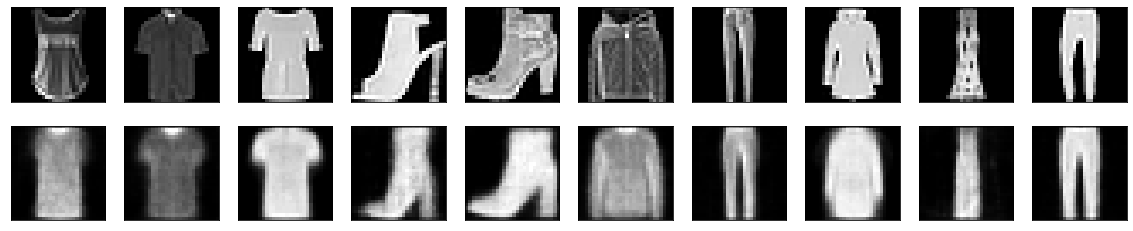

In [37]:
# Vị trí bất kì để trong tập dữ liệu để hiển thị ảnh
start = 2700

# Ảnh sau khi đã được giải mã
restored_imgs = vae_model.predict(X_train)

# Số lượng ảnh để hiển thị
n = 10
plt.figure(figsize=(20, 4))

for i in range(1, n + 1):
    # Vẽ ảnh gốc
    ax = plt.subplot(2, n, i)
    plt.imshow(X_train[i+start].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Vẽ ảnh đã được giải mã
    ax = plt.subplot(2, n, i + n)
    plt.imshow(restored_imgs[i+start].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

In [11]:
true_label = y_test

In [28]:
#Thử độ chính xác khi gom cụm dữ liệu với K-means kết hợp encoder để ánh xạ dữ liệu

encoded_imgs = encoder_model.predict(X_test)

encoded_imgs_reshape = [i.flatten() for i in encoded_imgs]

km_with_encoder = KMeans(n_clusters=10)
clustered_set_with_encoder = km_with_encoder.fit_predict(encoded_imgs_reshape)


print(adjusted_rand_score(true_label, clustered_set_with_encoder))

print(fowlkes_mallows_score(true_label, clustered_set_with_encoder))

0.3845373306139258
0.45335759046570256


In [29]:
#Thử độ chính xác khi gom cụm dữ liệu với K-means mà không sử dụng encoder để ánh xạ dữ liệu

km_without_encoder = KMeans(n_clusters=10)

imagearray_flattened = [i.flatten() for i in X_test]

clustered_set_without_encoder = km_without_encoder.fit_predict(imagearray_flattened)


print(adjusted_rand_score(true_label, clustered_set_without_encoder))

print(fowlkes_mallows_score(true_label, clustered_set_without_encoder))

0.3437875481067457
0.416379084460129
